<a href="https://colab.research.google.com/github/fagym/skin_lession_detection_mnist_ham_10015/blob/main/Xception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Connect to Dataset Kaggle**

In [ ]:
!pip install kaggle

import json
import os

from google.colab import files
files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
# Replace "DATASET_NAME" and "DATASET_PATH" with the actual name and path of the dataset
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

100% 5.19G/5.20G [00:47<00:00, 139MB/s]
100% 5.20G/5.20G [00:48<00:00, 116MB/s]


In [ ]:
# Replace "DATASET_FILE" with the actual name of the dataset file
!unzip skin-cancer-mnist-ham10000.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/ham10000_images_part_2/ISIC_0029325.jpg  
  inflating: /content/ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: /content/ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: /content/ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: /content/ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: /content/ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: /content/ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: /content/ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: /content/ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: /content/ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: /content/ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: /content/ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: /content/ham10000_images_part_2/ISIC_0029337.jpg  
  inflating: /content/ham10000_images_part_2/ISIC_0029338.jpg  
  inflating: /content/ham10000_images_part_2/ISIC_002

# **Create the Directory Structure**

In [ ]:
import pandas as pd
import numpy as np
import shutil
import tensorflow

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy, categorical_accuracy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix

import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Create a new directory
base_dir = 'base_dir'
os.mkdir(base_dir)

#[CREATE FOLDERS INSIDE THE BASE DIRECTORY]
# now we create 7 folders inside 'base_dir':

# create a path to 'base_dir' to which we will join the names of the new folders
# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)

# val_dir
test_dir = os.path.join(base_dir, 'test_dir')
os.mkdir(test_dir)

# [CREATE FOLDERS INSIDE THE TRAIN, VALIDATION AND TEST FOLDERS]
# Inside each folder we create seperate folders for each class

# create new folders inside train_dir
nv = os.path.join(train_dir, 'nv')
os.mkdir(nv)
mel = os.path.join(train_dir, 'mel')
os.mkdir(mel)
bkl = os.path.join(train_dir, 'bkl')
os.mkdir(bkl)
bcc = os.path.join(train_dir, 'bcc')
os.mkdir(bcc)
akiec = os.path.join(train_dir, 'akiec')
os.mkdir(akiec)
vasc = os.path.join(train_dir, 'vasc')
os.mkdir(vasc)
df = os.path.join(train_dir, 'df')
os.mkdir(df)

# create new folders inside val_dir
nv = os.path.join(val_dir, 'nv')
os.mkdir(nv)
mel = os.path.join(val_dir, 'mel')
os.mkdir(mel)
bkl = os.path.join(val_dir, 'bkl')
os.mkdir(bkl)
bcc = os.path.join(val_dir, 'bcc')
os.mkdir(bcc)
akiec = os.path.join(val_dir, 'akiec')
os.mkdir(akiec)
vasc = os.path.join(val_dir, 'vasc')
os.mkdir(vasc)
df = os.path.join(val_dir, 'df')
os.mkdir(df)

# create new folders inside test_dir
nv = os.path.join(test_dir, 'nv')
os.mkdir(nv)
mel = os.path.join(test_dir, 'mel')
os.mkdir(mel)
bkl = os.path.join(test_dir, 'bkl')
os.mkdir(bkl)
bcc = os.path.join(test_dir, 'bcc')
os.mkdir(bcc)
akiec = os.path.join(test_dir, 'akiec')
os.mkdir(akiec)
vasc = os.path.join(test_dir, 'vasc')
os.mkdir(vasc)
df = os.path.join(test_dir, 'df')
os.mkdir(df)

In [ ]:
#create variable containing train and val data
df_data = pd.read_csv('../content/HAM10000_metadata.csv')

# **Create Stratified Val Set**

In [ ]:
# this will tell us how many images are associated with each lesion_id
df = df_data.groupby('lesion_id').count()

# now we filter out lesion_id's that have only one image associated with it
df = df[df['image_id'] == 1]

df.reset_index(inplace=True)

In [ ]:
# here we identify lesion_id's that have duplicate images and those that have only
# one image.

def identify_duplicates(unique_id):

    unique_list = list(df['lesion_id'])

    if unique_id in unique_list:
        return 'no_duplicates'
    else:
        return 'has_duplicates'

# create a new colum that is a copy of the lesion_id column
df_data['duplicates'] = df_data['lesion_id']
# apply the function to this new column
df_data['duplicates'] = df_data['duplicates'].apply(identify_duplicates)

df_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,duplicates
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,has_duplicates
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,has_duplicates
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,has_duplicates
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,has_duplicates
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,has_duplicates


In [ ]:
df_data['duplicates'].value_counts()

no_duplicates     5514
has_duplicates    4501
Name: duplicates, dtype: int64

In [ ]:
# now we filter out images that don't have duplicates
df = df_data[df_data['duplicates'] == 'no_duplicates']

# **Devide a Train, Validation, and Test Data**

In [ ]:
# Create a validation set (df_val) using a stratified split based on the 'dx' column
y = df['dx']
df_train, df_val_and_test = train_test_split(df, test_size=0.37, random_state=101, stratify=y)

# Split the combined validation+test set into validation and test sets
df_val, df_test = train_test_split(df_val_and_test, test_size=0.5, random_state=101, stratify=df_val_and_test['dx'])

# Define a function to identify if an image is part of the train, validation, or test set
def identify_train_val_or_test_rows(x):
    val_list = list(df_val['image_id'])
    test_list = list(df_test['image_id'])
    if str(x) in val_list:
        return 'val'
    elif str(x) in test_list:
        return 'test'
    else:
        return 'train'

# Create a new column 'train_val_or_test' in df_data and apply the identify_val_or_test_rows function
df_data['train_val_or_test'] = df_data['image_id']
df_data['train_val_or_test'] = df_data['train_val_or_test'].apply(identify_train_val_or_test_rows)

# Filter out rows to create the train set (df_train), validation set (df_val), and test set (df_test)
df_train = df_data[df_data['train_val_or_test'] == 'train']
df_val = df_data[df_data['train_val_or_test'] == 'val']
df_test = df_data[df_data['train_val_or_test'] == 'test']

# Print the lengths of the train, validation, and test sets
print(len(df_train))
print(len(df_val))
print(len(df_test))


7974
1020
1021


In [ ]:
df_train['dx'].value_counts()

nv       5071
mel      1028
bkl       936
bcc       449
akiec     271
vasc      118
df        101
Name: dx, dtype: int64

In [ ]:
df_val['dx'].value_counts()

nv       817
bkl       81
mel       42
bcc       33
akiec     28
vasc      12
df         7
Name: dx, dtype: int64

In [ ]:
df_test['dx'].value_counts()

nv       817
bkl       82
mel       43
bcc       32
akiec     28
vasc      12
df         7
Name: dx, dtype: int64

# **Transfer Images into Folders**

In [ ]:
# Set the image_id as the index in df_data
df_data.set_index('image_id', inplace=True)

In [ ]:
# Get a list of images in each of the two folders
folder_1 = os.listdir('../content/ham10000_images_part_1')
folder_2 = os.listdir('../content/ham10000_images_part_2')

# Get a list of train, val, and test images
train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])
test_list = list(df_test['image_id'])

In [ ]:
# Transfer the train images

for image in train_list:

    fname = image + '.jpg'
    label = df_data.loc[image,'dx']

    if fname in folder_1:
        # source path to image
        src = os.path.join('../content/ham10000_images_part_1', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

    if fname in folder_2:
        # source path to image
        src = os.path.join('../content/ham10000_images_part_2', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

In [ ]:
# Transfer the val images

for image in val_list:

    fname = image + '.jpg'
    label = df_data.loc[image,'dx']

    if fname in folder_1:
        # source path to image
        src = os.path.join('../content/ham10000_images_part_1', fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

    if fname in folder_2:
        # source path to image
        src = os.path.join('../content/ham10000_images_part_2', fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

In [ ]:
# Transfer the test images

for image in test_list:

    fname = image + '.jpg'
    label = df_data.loc[image,'dx']

    if fname in folder_1:
        # source path to image
        src = os.path.join('../content/ham10000_images_part_1', fname)
        # destination path to image
        dst = os.path.join(test_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

    if fname in folder_2:
        # source path to image
        src = os.path.join('../content/ham10000_images_part_2', fname)
        # destination path to image
        dst = os.path.join(test_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

# **Augment Imbalanced Data**

In [ ]:
# note that we are not augmenting class 'nv'
class_list = ['mel','bkl','bcc','akiec','vasc','df']

for item in class_list:

    # We are creating temporary directories here because we delete these directories later
    # create a base dir
    aug_dir = 'aug_dir'
    os.mkdir(aug_dir)
    # create a dir within the base dir to store images of the same class
    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)

    # Choose a class
    img_class = item

    # list all images in that directory
    img_list = os.listdir('base_dir/train_dir/' + img_class)

    # Copy images from the class train dir to the img_dir e.g. class 'mel'
    for fname in img_list:
            # source path to image
            src = os.path.join('base_dir/train_dir/' + img_class, fname)
            # destination path to image
            dst = os.path.join(img_dir, fname)
            # copy the image from the source to the destination
            shutil.copyfile(src, dst)


    # point to a dir containing the images and not to the images themselves
    path = aug_dir
    save_path = 'base_dir/train_dir/' + img_class

    # Create a data generator
    datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        #brightness_range=(0.95,1.05),
        fill_mode='nearest')

    batch_size = 50

    aug_datagen = datagen.flow_from_directory(path,
                                           save_to_dir=save_path,
                                           save_format='jpg',
                                                    target_size=(224,224),
                                                    batch_size=batch_size)



    # Generate the augmented images and add them to the training folders

    ###########

    num_aug_images_wanted = 5000 # total number of images we want to have in each class

    ###########

    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((num_aug_images_wanted-num_files)/batch_size))

    # run the generator and create about 6000 augmented images
    for i in range(0,num_batches):

        imgs, labels = next(aug_datagen)

    # delete temporary directory with the raw image files
    shutil.rmtree('aug_dir')

Found 1028 images belonging to 1 classes.
Found 936 images belonging to 1 classes.
Found 449 images belonging to 1 classes.
Found 271 images belonging to 1 classes.
Found 118 images belonging to 1 classes.
Found 101 images belonging to 1 classes.


In [ ]:
# Check how many train images we now have in each folder.
# This is the original images plus the augmented images.

print(len(os.listdir('base_dir/train_dir/nv')))
print(len(os.listdir('base_dir/train_dir/mel')))
print(len(os.listdir('base_dir/train_dir/bkl')))
print(len(os.listdir('base_dir/train_dir/bcc')))
print(len(os.listdir('base_dir/train_dir/akiec')))
print(len(os.listdir('base_dir/train_dir/vasc')))
print(len(os.listdir('base_dir/train_dir/df')))

5071
4962
4980
5039
4586
3994
3433


# **Set Up Generators**

In [ ]:
train_path = 'base_dir/train_dir'
val_path = 'base_dir/val_dir'
test_path = 'base_dir/test_dir'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
batch_size = 64
image_size = 224

train_steps = np.ceil(num_train_samples / batch_size)
val_steps = np.ceil(num_val_samples / batch_size)

In [ ]:
datagen = ImageDataGenerator(
    preprocessing_function= \
    tensorflow.keras.applications.mobilenet.preprocess_input)

train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size)

val_batches = datagen.flow_from_directory(val_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size)


test_batches = datagen.flow_from_directory(test_path,
                                            target_size=(image_size,image_size),
                                            batch_size=1,
                                            shuffle=False)

Found 32065 images belonging to 7 classes.
Found 1020 images belonging to 7 classes.
Found 1021 images belonging to 7 classes.


# **Modify Model**

In [ ]:
# create a copy of a Xception
xception = tensorflow.keras.applications.xception.Xception(include_top=False, input_shape=(224,224,3))

83683744/83683744 [==============================] - 1s 0us/step


In [ ]:
# CREATE THE MODEL ARCHITECTURE

# Create a new dense layer for predictions
# add a global spatial average pooling layer
x = xception.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)

# add a fully connected layer and dropout
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(7, activation='softmax')(x)

model = Model(inputs=xception.input, outputs=x)

In [ ]:
for layer in xception.layers:
    layer.trainable=False

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

# **Train Model**

In [ ]:
initial_lr=0.01

model.compile(Adam(lr=initial_lr), loss='categorical_crossentropy',
              metrics=[categorical_accuracy])

In [ ]:
filepath = "best_xception.h5"

# Define a simple earlystop
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.001,
                          patience=3, mode='min', verbose=1)

# Save the best model as best_mobilenet.h5
checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1,
                             save_best_only=True, mode='max')

# Reduce the learning rate as the learning stagnates
reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=2,
                              verbose=1, mode='max', min_lr=0.00001)

callbacks_list = [earlystop, checkpoint, reduce_lr]

history = model.fit(train_batches,
                    steps_per_epoch=train_steps,
                    validation_data=val_batches,
                    validation_steps=val_steps,
                    epochs=30, verbose=1,
                    callbacks=callbacks_list)

Epoch 1/30
125/125 [==============================] - ETA: 0s - loss: 1.8270 - categorical_accuracy: 0.5301
Epoch 1: val_categorical_accuracy improved from -inf to 0.77745, saving model to best_xception.h5
125/125 [==============================] - 67s 413ms/step - loss: 1.8270 - categorical_accuracy: 0.5301 - val_loss: 0.6691 - val_categorical_accuracy: 0.7775 - lr: 0.0010
Epoch 2/30
125/125 [==============================] - ETA: 0s - loss: 1.2938 - categorical_accuracy: 0.6129
Epoch 2: val_categorical_accuracy improved from 0.77745 to 0.83431, saving model to best_xception.h5
125/125 [==============================] - 49s 388ms/step - loss: 1.2938 - categorical_accuracy: 0.6129 - val_loss: 0.5178 - val_categorical_accuracy: 0.8343 - lr: 0.0010
Epoch 3/30
125/125 [==============================] - ETA: 0s - loss: 1.0692 - categorical_accuracy: 0.6494
Epoch 3: val_categorical_accuracy did not improve from 0.83431
125/125 [==============================] - 48s 387ms/step - loss: 1.0692

# **Evaluate the Model**

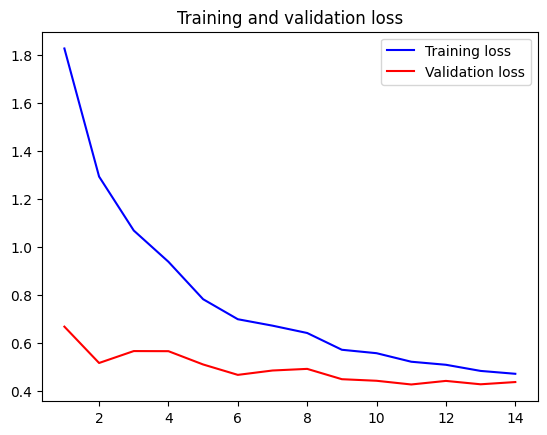

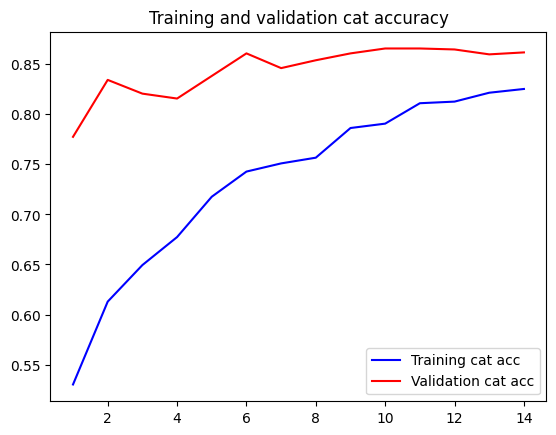

<Figure size 640x480 with 0 Axes>

In [ ]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'b', label='Training cat acc')
plt.plot(epochs, val_acc, 'r', label='Validation cat acc')
plt.title('Training and validation cat accuracy')
plt.legend()
plt.figure()

plt.show()

In [ ]:
test_score = model.evaluate_generator(test_batches)

print("[INFO] accuracy: {:.2f}%".format(test_score[1] * 100))
print("[INFO] Loss: ",test_score[0])

<ipython-input-32-6b2f8edd6b4e>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_score = model.evaluate_generator(test_batches)


[INFO] accuracy: 85.11%
[INFO] Loss:  0.4919307827949524


<ipython-input-35-01cd8c6ad48a>:30: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(test_batches)


Confusion Matrix
Classification Report
              precision    recall  f1-score   support

       akiec       0.52      0.39      0.45        28
         bcc       0.43      0.50      0.46        32
         bkl       0.57      0.48      0.52        82
          df       0.67      0.29      0.40         7
         mel       0.36      0.33      0.34        43
          nv       0.93      0.96      0.94       817
        vasc       0.50      0.42      0.45        12

    accuracy                           0.85      1021
   macro avg       0.57      0.48      0.51      1021
weighted avg       0.84      0.85      0.84      1021



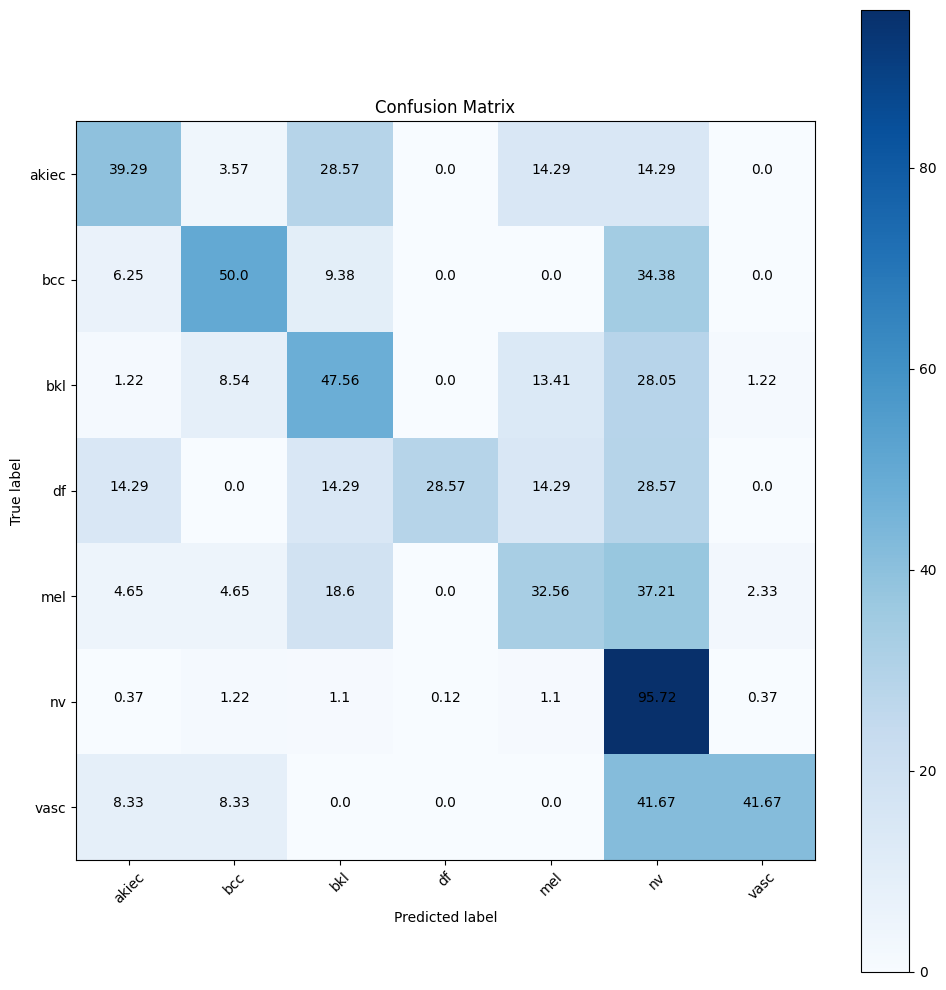

In [ ]:
class_names = []
for key in train_batches.class_indices:
    class_names.append(key)

#Plot the confusion matrix.

def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="black")

#Confution Matrix

Y_pred = model.predict_generator(test_batches)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_batches.classes
print('Confusion Matrix')

cm = confusion_matrix(y_true, y_pred)
cm_sum = np.sum(cm, axis=1, keepdims=True)
cm_perc = cm / cm_sum.astype(float) * 100
cm = np.around(cm_perc, decimals=2)
cm[np.isnan(cm)] = 0.0


plot_confusion_matrix(cm, class_names, title='Confusion Matrix')


#Print Classification Report
print('Classification Report')
print(classification_report(y_true, y_pred, target_names=class_names))

# **Re-train the model based on best weights**

In [ ]:
model.load_weights("best_xception.h5")

for layer in xception.layers:
   layer.trainable = True

In [ ]:
initial_lr=0.01

model.compile(Adam(lr=initial_lr), loss='categorical_crossentropy',
              metrics=[categorical_accuracy])

In [ ]:
filepath = "best_xception_tuned.h5"

# Define a simple earlystop
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.001,
                          patience=5, mode='min', verbose=1)

# Save the best model as best_mobilenet.h5
checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1,
                             save_best_only=True, mode='max')

# Reduce the learning rate as the learning stagnates
reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=2,
                              verbose=1, mode='max', min_lr=0.00001)

callbacks_list = [earlystop, checkpoint, reduce_lr]

retrain_history = model.fit(train_batches,
                    steps_per_epoch=train_steps,
                    validation_data=val_batches,
                    validation_steps=val_steps,
                    epochs=30, verbose=1,
                    callbacks=callbacks_list)

Epoch 1/30
125/125 [==============================] - ETA: 0s - loss: 0.9229 - categorical_accuracy: 0.6696
Epoch 1: val_categorical_accuracy improved from -inf to 0.39804, saving model to best_xception_tuned.h5
125/125 [==============================] - 169s 1s/step - loss: 0.9229 - categorical_accuracy: 0.6696 - val_loss: 7.2135 - val_categorical_accuracy: 0.3980 - lr: 0.0010
Epoch 2/30
125/125 [==============================] - ETA: 0s - loss: 0.5931 - categorical_accuracy: 0.7886
Epoch 2: val_categorical_accuracy improved from 0.39804 to 0.81176, saving model to best_xception_tuned.h5
125/125 [==============================] - 125s 999ms/step - loss: 0.5931 - categorical_accuracy: 0.7886 - val_loss: 0.6050 - val_categorical_accuracy: 0.8118 - lr: 0.0010
Epoch 3/30
125/125 [==============================] - ETA: 0s - loss: 0.4374 - categorical_accuracy: 0.8441
Epoch 3: val_categorical_accuracy improved from 0.81176 to 0.81667, saving model to best_xception_tuned.h5
125/125 [========

# **Evaluate the Model**

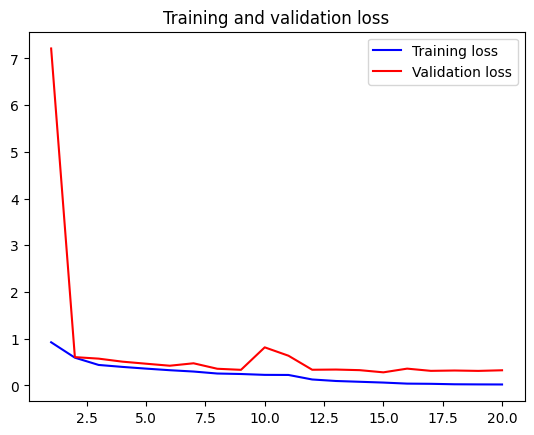

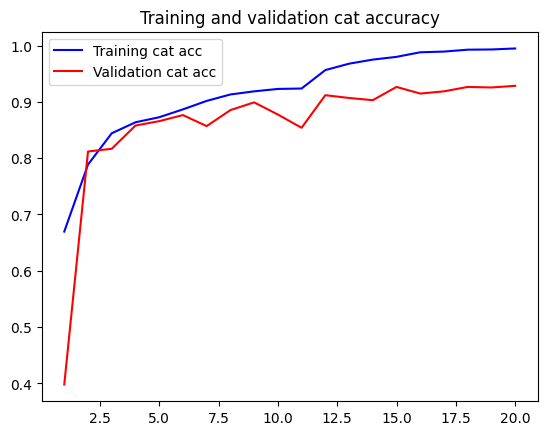

<Figure size 640x480 with 0 Axes>

In [ ]:
acc = retrain_history.history['categorical_accuracy']
val_acc = retrain_history.history['val_categorical_accuracy']
loss = retrain_history.history['loss']
val_loss = retrain_history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'b', label='Training cat acc')
plt.plot(epochs, val_acc, 'r', label='Validation cat acc')
plt.title('Training and validation cat accuracy')
plt.legend()
plt.figure()

plt.show()

In [ ]:
test_score = model.evaluate_generator(test_batches)

print("[INFO] accuracy: {:.2f}%".format(test_score[1] * 100))
print("[INFO] Loss: ",test_score[0])

<ipython-input-42-6b2f8edd6b4e>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_score = model.evaluate_generator(test_batches)


[INFO] accuracy: 93.34%
[INFO] Loss:  0.24848127365112305


<ipython-input-43-9f42d1fc4b66>:29: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(test_batches)


Confusion Matrix
Classification Report
              precision    recall  f1-score   support

       akiec       0.75      0.75      0.75        28
         bcc       0.91      0.91      0.91        32
         bkl       0.83      0.72      0.77        82
          df       1.00      0.71      0.83         7
         mel       0.63      0.63      0.63        43
          nv       0.96      0.98      0.97       817
        vasc       1.00      0.92      0.96        12

    accuracy                           0.93      1021
   macro avg       0.87      0.80      0.83      1021
weighted avg       0.93      0.93      0.93      1021



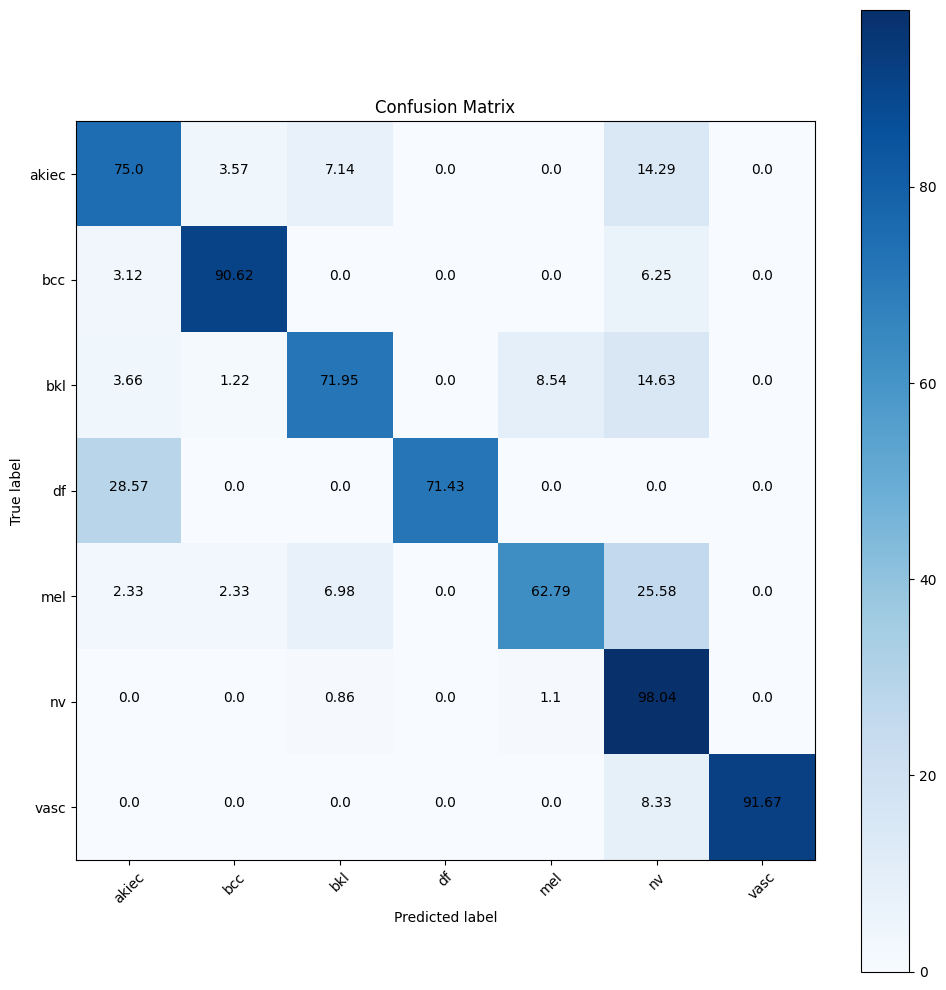

In [ ]:
#Plot the confusion matrix.

def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


#Confution Matrix

Y_pred = model.predict_generator(test_batches)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')

cm = confusion_matrix(test_batches.classes, y_pred)
cm_sum = np.sum(cm, axis=1, keepdims=True)
cm_perc = cm / cm_sum.astype(float) * 100
cm = np.around(cm_perc, decimals=2)
cm[np.isnan(cm)] = 0.0


plot_confusion_matrix(cm, class_names, title='Confusion Matrix')


#Print Classification Report
print('Classification Report')
print(classification_report(test_batches.classes, y_pred, target_names=class_names))

# **Export Model**

In [ ]:
model.save('xception_skin.h5')

In [ ]:
# Load the model from the file
model = tensorflow.keras.models.load_model('xception_skin.h5')

# Convert the model to the TensorFlow Lite format
converter = tensorflow.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to a file
open("converted_xception.tflite", "wb").write(tflite_model)


91594348